# Module 4 - Margin and Ensemble Classifiers

Before the popularization of deep learning, many applied automatic classification algorithms were variations on ensemble or margin classifiers. Both types of classifiers operate on pre-defined features. As we will see later, this is fundamentally different from neural networks which can learn directly from the images. For now, we will make use of the features pulled from SPC data in the last module.

In [19]:
import numpy as np
import cv2
import skimage
from sklearn import ensemble
from sklearn import svm
from sklearn import preprocessing
import sys
import glob
import os
import random
import matplotlib.pyplot
sys.path.append(os.path.join(os.getcwd(),'utilities'))
from display_utils import make_confmat

The important new toolkit we are importing here is *sklearn*, short for scikit-image. It contains most of the tools we will use to explore margin and ensemble classifiers.

## Importing features, dividing into training and test sets

For all the techinques discussed in the rest of this module, we will make use of the same features we computed before. We will also need to divide it into seperate sets for training and testing. 

In [2]:
# load in the data. first get all the file paths
ptf = glob.glob(os.path.join("/media/storage/image_data/SPC_data/manual_labels_features/","*.csv"))

# initalize a dictionary for the data. This will contain all the file paths and the associated features
data = dict()

# we will also create a flag and a listto give the labels a numeric value
flag = 0
cls_names = []

for line in ptf:

    # read in the data, but skip the image path
    temp = np.genfromtxt(line, usecols=range(1,71),delimiter=",")
    
    # get the image path, making sure to specify that the data type is string
    temp_path = np.genfromtxt(line, usecols= [0], delimiter=",", dtype=np.str)
    
    # for now, we will ignore any classes with fewer than 10 samples
    if 10 < temp.shape[0]:
        
        # now we are creating a "nested dictionary." Each element is referenced by the image id and contains the features
        # and numeric class label
        for img, feats in zip(temp_path, temp):
            data[img] = {'features': feats, 'class': flag}
            
        # create a list of the names of the categories and the associated numbers
        name = line.split('/')[-1].split('_')[0]
        print("class", str(flag), ":", name, 
              ", num images:", str(temp.shape[0]))
        cls_names.append((flag, name))
        
        flag+=1

print("Total class:", str(flag), ", Total images:", str(len(data)))

class 0 : Ciliate 01 , num images: 424
class 1 : Glob , num images: 16
class 2 : Acantharea , num images: 24
class 3 : Poop 01 , num images: 63
class 4 : Bubble , num images: 331
class 5 : Sphere 01 , num images: 38
class 6 : Bad Seg , num images: 249
class 7 : Akashiwo , num images: 447
class 8 : Polykrikos , num images: 331
class 9 : Nauplius , num images: 336
class 10 : Ellipse 01 , num images: 43
class 11 : Lingulodinium , num images: 653
class 12 : Protoperidinium Feeding , num images: 11
class 13 : Ciliate 02 , num images: 14
class 14 : Chain 01 , num images: 352
class 15 : Diatom chain , num images: 60
class 16 : Round 01 , num images: 65
class 17 : Phyto Mix 01 , num images: 895
class 18 : Ciliate 03 , num images: 24
class 19 : Ceratium fusus , num images: 1011
class 20 : Avocado 01 , num images: 62
class 21 : Ceratium furca two , num images: 38
class 22 : Cochlodinium , num images: 332
class 23 : Red Eye , num images: 44
class 24 : Prorocentrum Skinny , num images: 472
class 2

We now have 38 classes, comprising a total of 20678 samples. The nested dictionary is how we will interact with the data. Each data point is identified by its image ID that is saved as a dictionary key.

Note that we are using python 3.6 which by default preserves the order of the dictionary. That is, the order of the key-value pairs will remain the same as how they were inserted into the dictionary no matter what. If for some reason you use an earlier version of python, be aware that the order may not be preserved. 

In [3]:
# to get a list of all the dictionary keys use Python's built in list command and the dictionary method keys()
img_ids = list(data.keys())

print("the first sample is:", img_ids[0])

the first sample is: SPCP2-1522716755-312771-000-584-2524-224-128.jpg


We will use this later to display images after they have been classifier. We can call up the information from that particular image by calling that key's associated values from the dictionary.

In [4]:
# get the data related to a particular sample put the key in square brackets
# remember, the data is store as a dictionary itself. We can also print those keys in the same way

print(img_ids[0], "has two keys that can be referenced:", data[img_ids[0]].keys())

SPCP2-1522716755-312771-000-584-2524-224-128.jpg has two keys that can be referenced: dict_keys(['features', 'class'])


Now we can call the features and the class of that first sample.

In [5]:
# to retrieve the class
print("the numeric class is:", data[img_ids[0]]['class'])

# and the features
print("the features are:",  data[img_ids[0]]['features'])

the numeric class is: 0
the features are: [  5.67235429e-01   8.06082589e-01   2.07103476e-02   8.06082589e-01
   2.31120000e+04   8.23555686e-01   1.71543325e+02   0.00000000e+00
   2.84408754e-01   2.12988031e-02   5.75023115e-05   1.03953474e-04
   7.80014848e-09   1.38600425e-05   1.93731586e-09   2.59058582e-01
   4.84876658e-02   2.20199150e-01   4.62453373e-02   9.70800133e-03
   1.31577215e-01   3.45316281e+00   1.79048225e+00   2.35758892e+00
   4.25905750e+00   6.33965540e+00   7.17331783e+00   7.08213941e+00
   9.46854563e-01   9.37746789e-01   9.11843519e-01   8.76248868e-01
   8.59548187e-01   8.64953747e-01   9.08297483e-01   9.03828887e-01
   8.84937543e-01   8.45380756e-01   8.25986643e-01   8.34588555e-01
   7.12060569e-01   6.21818771e-01   3.28782904e-01   7.30131012e-02
   2.06799996e-02   2.69482227e-02   3.39578263e-01   3.40777531e-01
   3.92849714e-01   5.25042430e-01   3.86037203e-01   8.28412190e-01
   6.53627647e-03   5.30657990e-03   6.19726627e-03   8.81415

Now that we have all the data in the workspace, we need to divide it up for training and testing. That is we need to seperate out a subset of the training data to use as an independent set to assess how well the classifier is doing. 

To do the data dictionary needs to be randomized and split into a training and test set. Here we will use an 80-20 train-test split; 80% of the data will be used to train and 20% will be reserved for testing. 

In [6]:
# to avoid copying the dictionary multiple times, we will randomize the list of keys (ie the image IDs) we made above.
random.shuffle(img_ids)

# print one out to double check
print("The new first entry is:", img_ids[0])

The new first entry is: SPCP2-1523396894-214021-005-1604-16-72-48.jpg


In [7]:
# now we can split the list into training and test sets based on the number of entries
idx = 0.8*len(img_ids)

train_ids = img_ids[0:int(idx)]  # this will copy all the image ids from 0 to the 80% cut-off
test_ids = img_ids[int(idx)::]  # this will copy all the image ids from the cut-off to the end

# double check
print("cut off for 80-20 split:", str(int(idx)))
print("number of training images:", str(len(train_ids)))
print("nubmer of test images:", str(len(test_ids)))

cut off for 80-20 split: 16542
number of training images: 16542
nubmer of test images: 4136


With the data split by the image ID, we can select the training and test sets. 

In [8]:
# to train it, feed in the features and labels

# pull out the features for the training data
# the next line uses "list comprehension" to pull out the feature vectors only from the trianing data
train_features = [data[line]['features'] for line in train_ids]
train_features = np.asarray(train_features)  # convert to an array

# retrieve the numeric classes of the training data
train_labels = [data[line]['class'] for line in train_ids]
train_labels = np.asarray(train_labels)  # convert to an array

# check to make sure these numbers are right. We expect the training features to be a matrix with 
# dimensions [n_images x n_features] and the training labels to be a matrix with dimensions [n_images x 1]
print("train features dim:", train_features.shape)
print("train labels dim:", train_labels.shape)

train features dim: (16542, 70)
train labels dim: (16542,)


In [9]:
# to test it, feed in the features and labels from the test data

# pull out the features for the test data
# the next line uses "list comprehension" to pull out the feature vectors only from the trianing data
test_features = [data[line]['features'] for line in test_ids]
test_features = np.asarray(test_features)  # convert to an array

# retrieve the numeric classes of the training data
test_labels = [data[line]['class'] for line in test_ids]
test_labels = np.asarray(test_labels)  # convert to an array

# check to make sure these numbers are right. We expect the test features to be a matrix with 
# dimensions [n_images x n_features] and the test labels to be a matrix with dimensions [n_images x 1]
print("test features dim:", test_features.shape)
print("test labels dim:", test_labels.shape)

test features dim: (4136, 70)
test labels dim: (4136,)


The features and labels are now divided into training and test sets that we can use multiple times. The order of these will remain the same and correspond witht the order of the image IDs. 

## Feature standardization

It is good practice to standardize the features before feeding them into an ensemble or margin classifier. Here, standardization simply means making each feature look a Gaussian with zero mean and unit variance. SKLearn provides a class to fit a standardizer, save it, and apply it to both training and test data. 

In [18]:
# invoke an instance of the standardizer class and fit it to the training features
scale_transform = preprocessing.StandardScaler().fit(train_features)

# The scale_transform instance stores all the information we need for the transformer
# print the mean of each feature
print("mean of first feature:", scale_transform.mean_[0])

mean of first feature: 0.736817398497


Excellent. Now that the data is imported into the workspace in an organized way and the transformer prepared, we can begin training and testing classifiers. The same training and test data will be used for the both margin and ensemble classifiers. 

## Margin classifiers

A margin classifier seperates data in a space by assigning a distance between each point and the decision boundary. Imagine that we have just 2 features, $x_{1}$ and $x_{2}$, to seperate two classes. We can plot the points in a plane and find a line that seperates them.


<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg">
    <figcaption>
        Points and hyperplanes. Courtesy: ZackWeinberg, via Wikipedia
    </figcaption>
</figure>
        

The line labeled $H_{3}$ is the best linear discriminant of this data. 

A classic and widely used margin classifier is the *support vector machine* (SVM). SVMs search a space, definied by the features, to find the optimal seperating hyperplane (ie a plane in many dimensions). In the example above, it would iteratively try many lines such as $H_{1}$ and $H_{2}$ before eventually settling on a particular plane.

We will use the implimentation in SKLearn, svc -- a class that contains all functions need to train, test, and deplpoy a SVM. Do note however, that fitting a SVM is computationally expensive and scales quadratically. In other words, training an SVM with O(10k) samples becomes really time consuming and memory hungry.  

In [20]:
# first create an instance of the SVM
svm_clf = svm.SVC(kernel='linear')

The kernerl parameter tells SKLearn how to seperate the data. A 'linear' kernerl will attempt to find linear decision boundaries. 

In [21]:
# train the SVM (this may take a few minutes)
# the first parameter is the training features. Make sure to scale them!
# the second parameter is the training labels. These do not need to be scaled
svm_clf.fit(scale_transform.transform(train_features), train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Once trained, the classifier will show a bunch of information about the classifier. We can now apply it to new data to see how accurate it is.

In [22]:
# run the new data through the classifier to get the mean accuracy
# the first parameter is the test data. Remember to scale it
acc_svm = svm_clf.score(scale_transform.transform(test_features), test_labels)

print("Linear SVM accuracy:", acc_svm)

Linear SVM accuracy: 0.758462282398


We can visualize the accuracy of the classifier using a *confusion matrix* that compares the classifier labels to the true labels.  

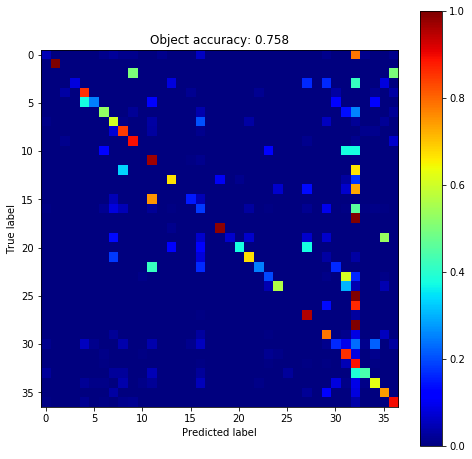

In [24]:
# To plot the confusion matrix, we need the predicitons from the classifier on an image-by-image basis.
svm_preds = svm_clf.predict(scale_transform.transform(test_features))

# feed the predictions and the true labels to a confusion matrix plotting utility
make_confmat(test_labels, svm_preds, acc_svm)

## Ensemble classifiers

Rather than relying on the results of a single classifer, ensemble classifier combine the results of many smaller classifiers. There are many ways of generating such a collection of computer classifiers. Here we will focus on the popular random forest (RFs) models. 

RFs build a collection of decision trees built from a random selection of the feature set. A single decision tree is a type of flow chart: each node in the tree is a test on a single feature and each branch denotes the outcome. A terminal node, or leaf, represents the tree's final classification.

A single decsion tree tends to overfit the data -- it become really good at representing the training data but does not generalize well to new data. RFs get around this by creating many trees, using a random subsample of features and training examples for each tree. A new sample is then fed into every tree and the results averaged at the end to come to a final decision.

To train a RF in python we will use the sklearn's ensemble methods.

In [8]:
# note we are only using a few of the RF parameters. There are many ways to modify this
rf_clf = ensemble.RandomForestClassifier(n_estimators=30, n_jobs=8, verbose=1)

We have not trained the classifier yet. The code above defines an instance *rf_clf* of the class *RandomForestClassifier*. The parameters we added define a few things:

* n_estimators is the number of trees. For now we are just using 30
* n_jobs parallalizes the process. It subdivides the process out to some number of cores. This speeds up training and is limited by the hardware you are working on. 
* verbose just tells sklearn they we want feedback as it is training. 

There are loads of other parameters that can change how the classifier behaves. For our purposes, mostly using defaults will suffice. Note that we are not exlicitly defining the number of features the will be used in each random tree. The default as set by sklearn is $\sqrt(n_features)$. This is generally a good rule of thumb.

To train the classifier we need to give it data. This is done with the *fit* method of the *RandomForestClassifier*.

In [9]:
# to train it, feed in the features and labels

# pull out the features for the training data
# the next line uses "list comprehension" to pull out the feature vectors only from the trianing data
train_features = [data[line]['features'] for line in train_ids]
train_features = np.asarray(train_features)  # convert to an array

# retrieve the numeric classes of the training data
train_labels = [data[line]['class'] for line in train_ids]
train_labels = np.asarray(train_labels)  # convert to an array

# check to make sure these numbers are right. We expect the training features to be a matrix with 
# dimensions [n_images x n_features] and the training labels to be a matrix with dimensions [n_images x 1]
print("train features dim:", train_features.shape)
print("train labels dim:", train_labels.shape)

train features dim: (16542, 70)
train labels dim: (16542,)


In [10]:
# now plug into the fit method. this step might take a little while
rf_clf.fit(train_features, train_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

All done! The classifier is trained. Now we can test it on the independent set that it has not seen yet. 

In [11]:
# to test it, feed in the features and labels from the test data

# pull out the features for the test data
# the next line uses "list comprehension" to pull out the feature vectors only from the trianing data
test_features = [data[line]['features'] for line in test_ids]
test_features = np.asarray(test_features)  # convert to an array

# retrieve the numeric classes of the training data
test_labels = [data[line]['class'] for line in test_ids]
test_labels = np.asarray(test_labels)  # convert to an array

# check to make sure these numbers are right. We expect the test features to be a matrix with 
# dimensions [n_images x n_features] and the test labels to be a matrix with dimensions [n_images x 1]
print("test features dim:", test_features.shape)
print("test labels dim:", test_labels.shape)

test features dim: (4136, 70)
test labels dim: (4136,)


In [12]:
# now plug it into the trained classifier
acc = rf_clf.score(test_features, test_labels)

print(acc, '% correct')

0.7166344294 % correct


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished


Not too bad. But we need a way of visualizing what classes it had trouble with. 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished


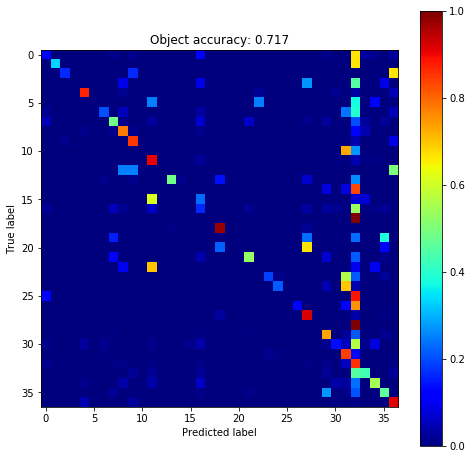

In [13]:
# get the labels for the test set from the classifier
preds = rf_clf.predict(test_features)

# make a confusion matrix
make_confmat(test_labels, preds, acc)

In the ideal case, this matrix would be purely diagonal. The class at index 32 is particularly interesting. There seems to be a lot of data going there. Which one is it?

In [14]:
cls_names[32]

(32, 'Skinny Mix 01')

Skinny mix is a mishmash class. It seems like one that the classifier could easily confuse. It is also a big class (~2k images) relative to some of the small ones. This means there is some variability in that might not have been captured in the training data for some of the spase classes. 